# Data Loading

In [15]:
import kagglehub

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:02<00:00, 31.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)


# Set Matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

file_path = '/home/mohammadseyfi/Desktop/deeplearning/Credit_Card_Fraud_Detection/creditcard.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset 'creditcard.csv' loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows of the DATASET:")
    print(df.head())

except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please ensure the file is in the correct Kaggle input directory.")
    exit()

Dataset 'creditcard.csv' loaded successfully.
Dataset shape: (284807, 31)

First 5 rows of the DATASET:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.2705

# Exploratory Data Analysis (EDA)


In [17]:
# Missing Values Check
print("\nMissing Values Check ---")

# Calculate the sum of null values for each column
missing_values = df.isnull().sum()

print("Count of missing values per column:")
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("\nData is clean regarding nulls.")
else:
    print(f"\nTotal missing values: {missing_values.sum()}")


Missing Values Check ---
Count of missing values per column:
Series([], dtype: int64)

Data is clean regarding nulls.


# Why Use a Log Scale for 'Amount'?
1) Handles Skewness: Transaction amounts are often highly skewed to the right (positively skewed). A log transformation compresses the larger values and expands the smaller values, making the distribution appear more symmetrical and revealing details that might be hidden when using a linear scale.
2) Better Visibility Across Orders of Magnitude: It allows you to see patterns and variations across different orders of magnitude (amounts in the 10s, 100s, 1000s) more clearly on a single plot.
3) Highlighting Relative Changes: Log scales emphasize relative changes rather than absolute ones.

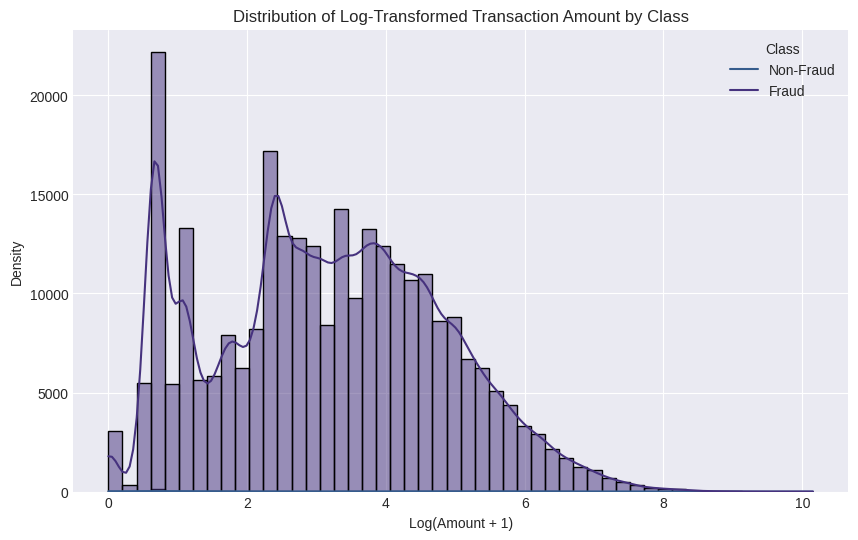

In [2]:
df['Log_Amount'] = np.log1p(df['Amount'])

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Log_Amount', hue='Class', kde=True, bins=50) # Adjust bins as needed
plt.title('Distribution of Log-Transformed Transaction Amount by Class')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Density') 
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()


Class Distribution Analysis (Target Variable: 'Class') 
Normalized Class Distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Absolute Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


<ipython-input-19-a6318fa9af65>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='coolwarm')


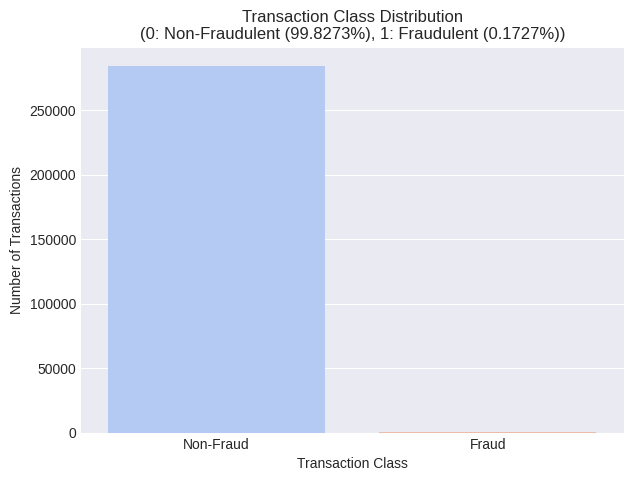

In [19]:
# Class Distribution Analysis
print("\nClass Distribution Analysis (Target Variable: 'Class') ")

# Calculate the normalized distribution of the 'Class' column (percentages)
class_distribution = df['Class'].value_counts(normalize=True)
print("Normalized Class Distribution:")
print(class_distribution)

# Calculate the absolute counts of each class
print("\nAbsolute Class Distribution:")
print(df['Class'].value_counts())

# Visualize the class distribution using a countplot
plt.figure(figsize=(7, 5))
sns.countplot(x='Class', data=df, palette='coolwarm')
plt.title(f"Transaction Class Distribution\n(0: Non-Fraudulent ({class_distribution[0]*100:.4f}%), 1: Fraudulent ({class_distribution[1]*100:.4f}%))")
plt.xlabel("Transaction Class")
plt.ylabel("Number of Transactions")
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud']) # Label x-axis for clarity
plt.show()

The results vividly illustrate the extreme class imbalance:

Class 0 (Non-Fraudulent): Accounts for approximately 99.827% of all transactions.
Class 1 (Fraudulent): Accounts for only about 0.173% of all transactions.
This profound imbalance has several critical implications:

Accuracy is a Misleading Metric: A naive model that simply predicts "Non-Fraud" for every transaction would achieve an accuracy of ~99.827%. This model would be completely useless for fraud detection, as it would miss all fraudulent cases. Therefore, we cannot rely solely on accuracy for model evaluation.
Focus on Specific Metrics: For fraud detection, our primary focus must be on metrics that assess performance on the minority class, such as Precision, Recall, F1-Score, and ROC AUC.
Specialized Handling Required: This imbalance necessitates the use of specific techniques during model training, such as class_weight='balanced' (which we'll use in our Decision Tree and other models).


Distribution of 'Time' and 'Amount' by Class 


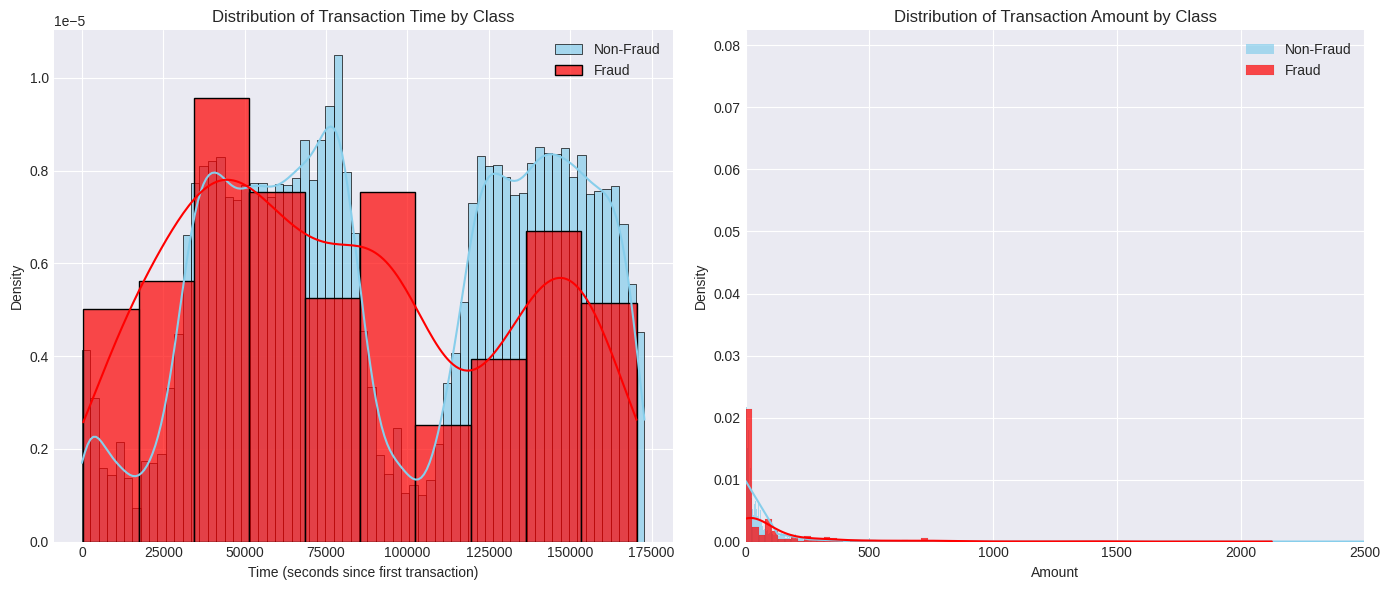

In [20]:
# Distribution of 'Time' and 'Amount' features by Class
print("\nDistribution of 'Time' and 'Amount' by Class ")
plt.figure(figsize=(14, 6))

# Plot distribution of 'Time' for both classes
plt.subplot(1, 2, 1)
sns.histplot(df[df['Class'] == 0]['Time'], kde=True, color='skyblue', label='Non-Fraud', stat='density', alpha=0.7)
sns.histplot(df[df['Class'] == 1]['Time'], kde=True, color='red', label='Fraud', stat='density', alpha=0.7)
plt.title('Distribution of Transaction Time by Class')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Density')
plt.legend()

# Plot distribution of 'Amount' for both classes
plt.subplot(1, 2, 2)
sns.histplot(df[df['Class'] == 0]['Amount'], kde=True, color='skyblue', label='Non-Fraud', stat='density', alpha=0.7)
sns.histplot(df[df['Class'] == 1]['Amount'], kde=True, color='red', label='Fraud', stat='density', alpha=0.7)
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Amount')
plt.ylabel('Density')

# Limit x-axis for better visibility as most transactions are small
plt.xlim(0, 2500)
plt.legend()
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

Time Distribution: Both legitimate and fraudulent transactions appear throughout the 'Time' spectrum. Fraudulent transactions seem to show a slightly different pattern, perhaps concentrating at certain time points, but no clear cut-off time exists that perfectly separates fraud from non-fraud. This feature might still be useful as a continuous variable.
Amount Distribution: The plot clearly shows that fraudulent transactions generally involve much smaller amounts compared to legitimate ones. While legitimate transactions span a very wide range of amounts, fraudulent transactions are heavily concentrated at the lower end (below ~$1000). This is a strong indicator that Amount will be a very important feature for fraud detection.


Distribution of Select Anonymized V-Features by Class


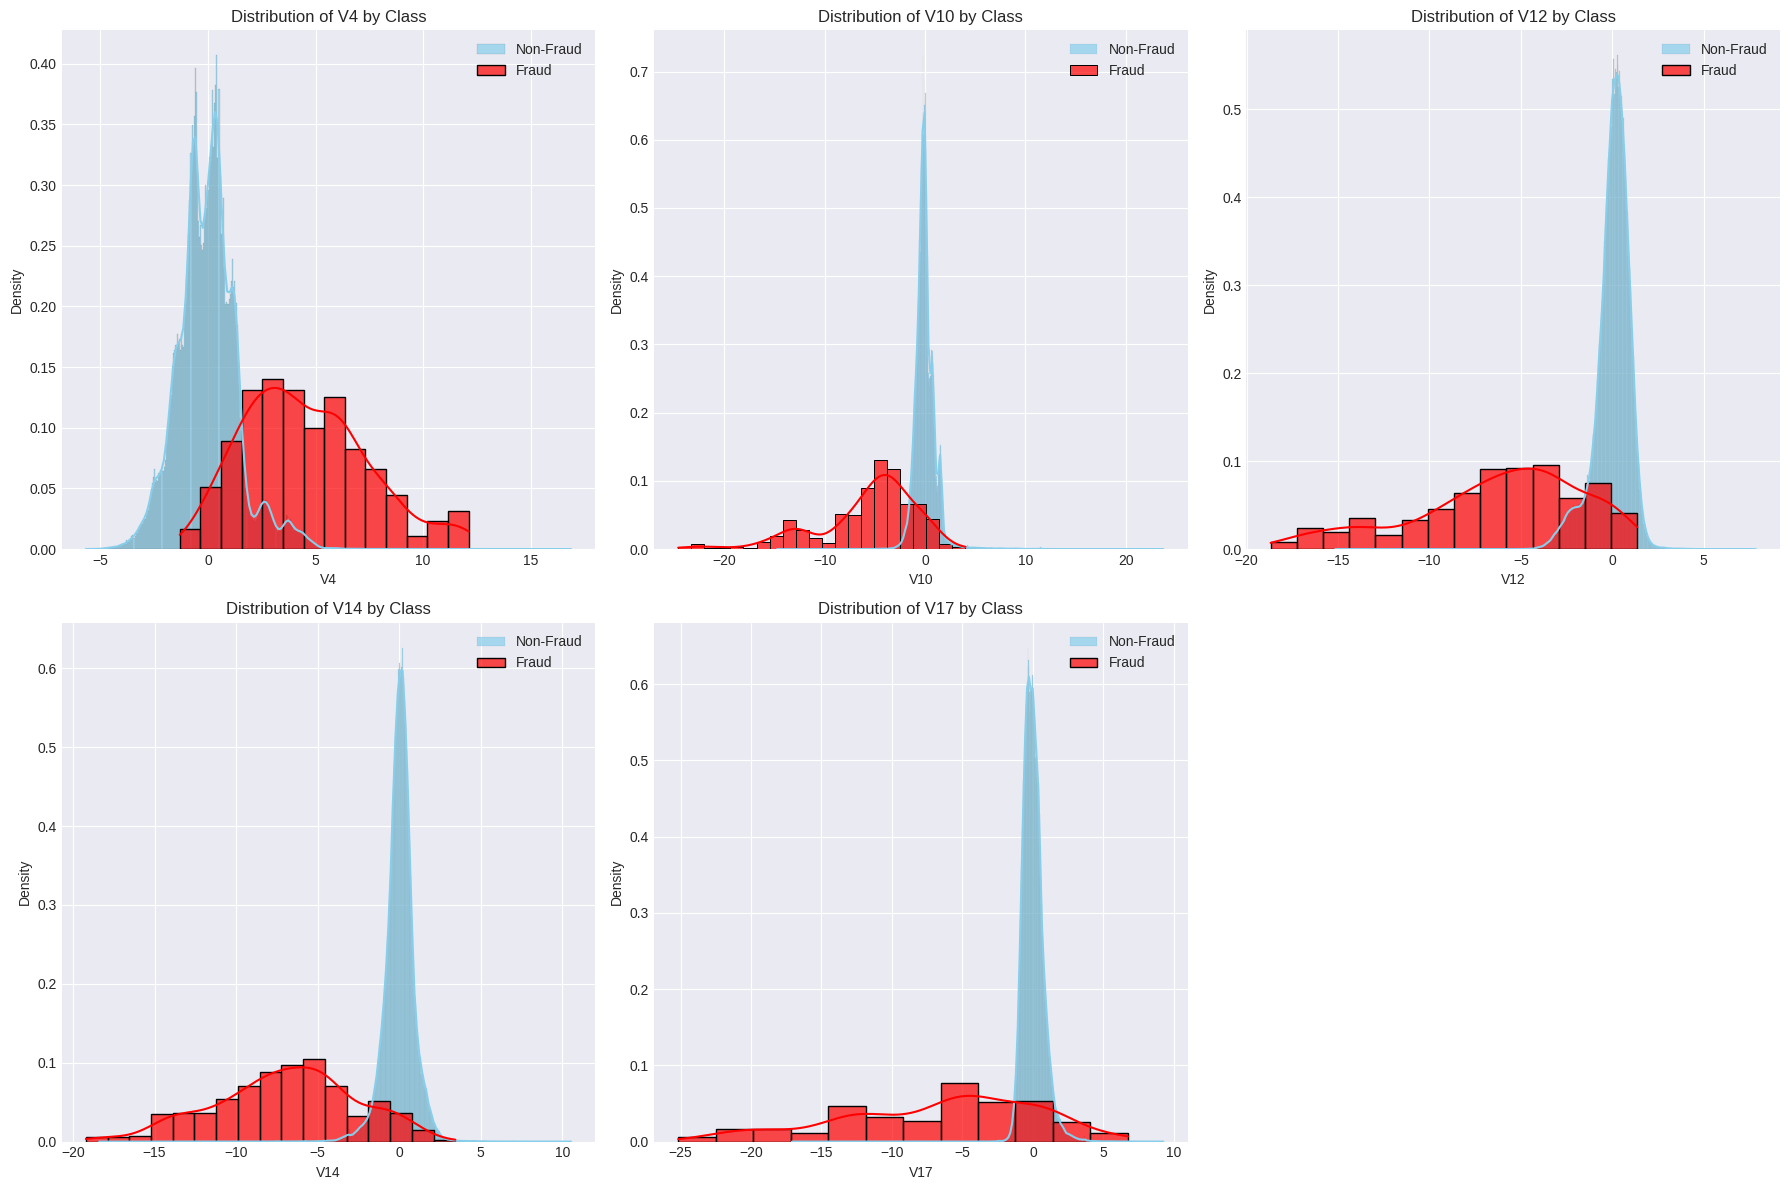

In [21]:
# Distribution of Select V-Features by Class (Visualizing Separation)
print("\nDistribution of Select Anonymized V-Features by Class")
# Choice a subset of V-features that are often highly discriminative for fraud
v_features_to_plot = ['V4', 'V10', 'V12', 'V14', 'V17']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(v_features_to_plot):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[df['Class'] == 0][feature], kde=True, color='skyblue', label='Non-Fraud', stat='density', alpha=0.7)
    sns.histplot(df[df['Class'] == 1][feature], kde=True, color='red', label='Fraud', stat='density', alpha=0.7)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

The plots for the selected V features demonstrate clear separation between the distributions of non-fraudulent and fraudulent transactions. For example:

V14 and V17: Show highly distinct distributions, with fraudulent transactions often exhibiting values in ranges where legitimate transactions are very sparse. This suggests these features are extremely important for identifying fraud.
V10, V12, V4: Also show noticeable differences, indicating their significant discriminative power.
These visual insights confirm that the PCA-transformed features, despite being anonymized, hold crucial information for our fraud detection model.

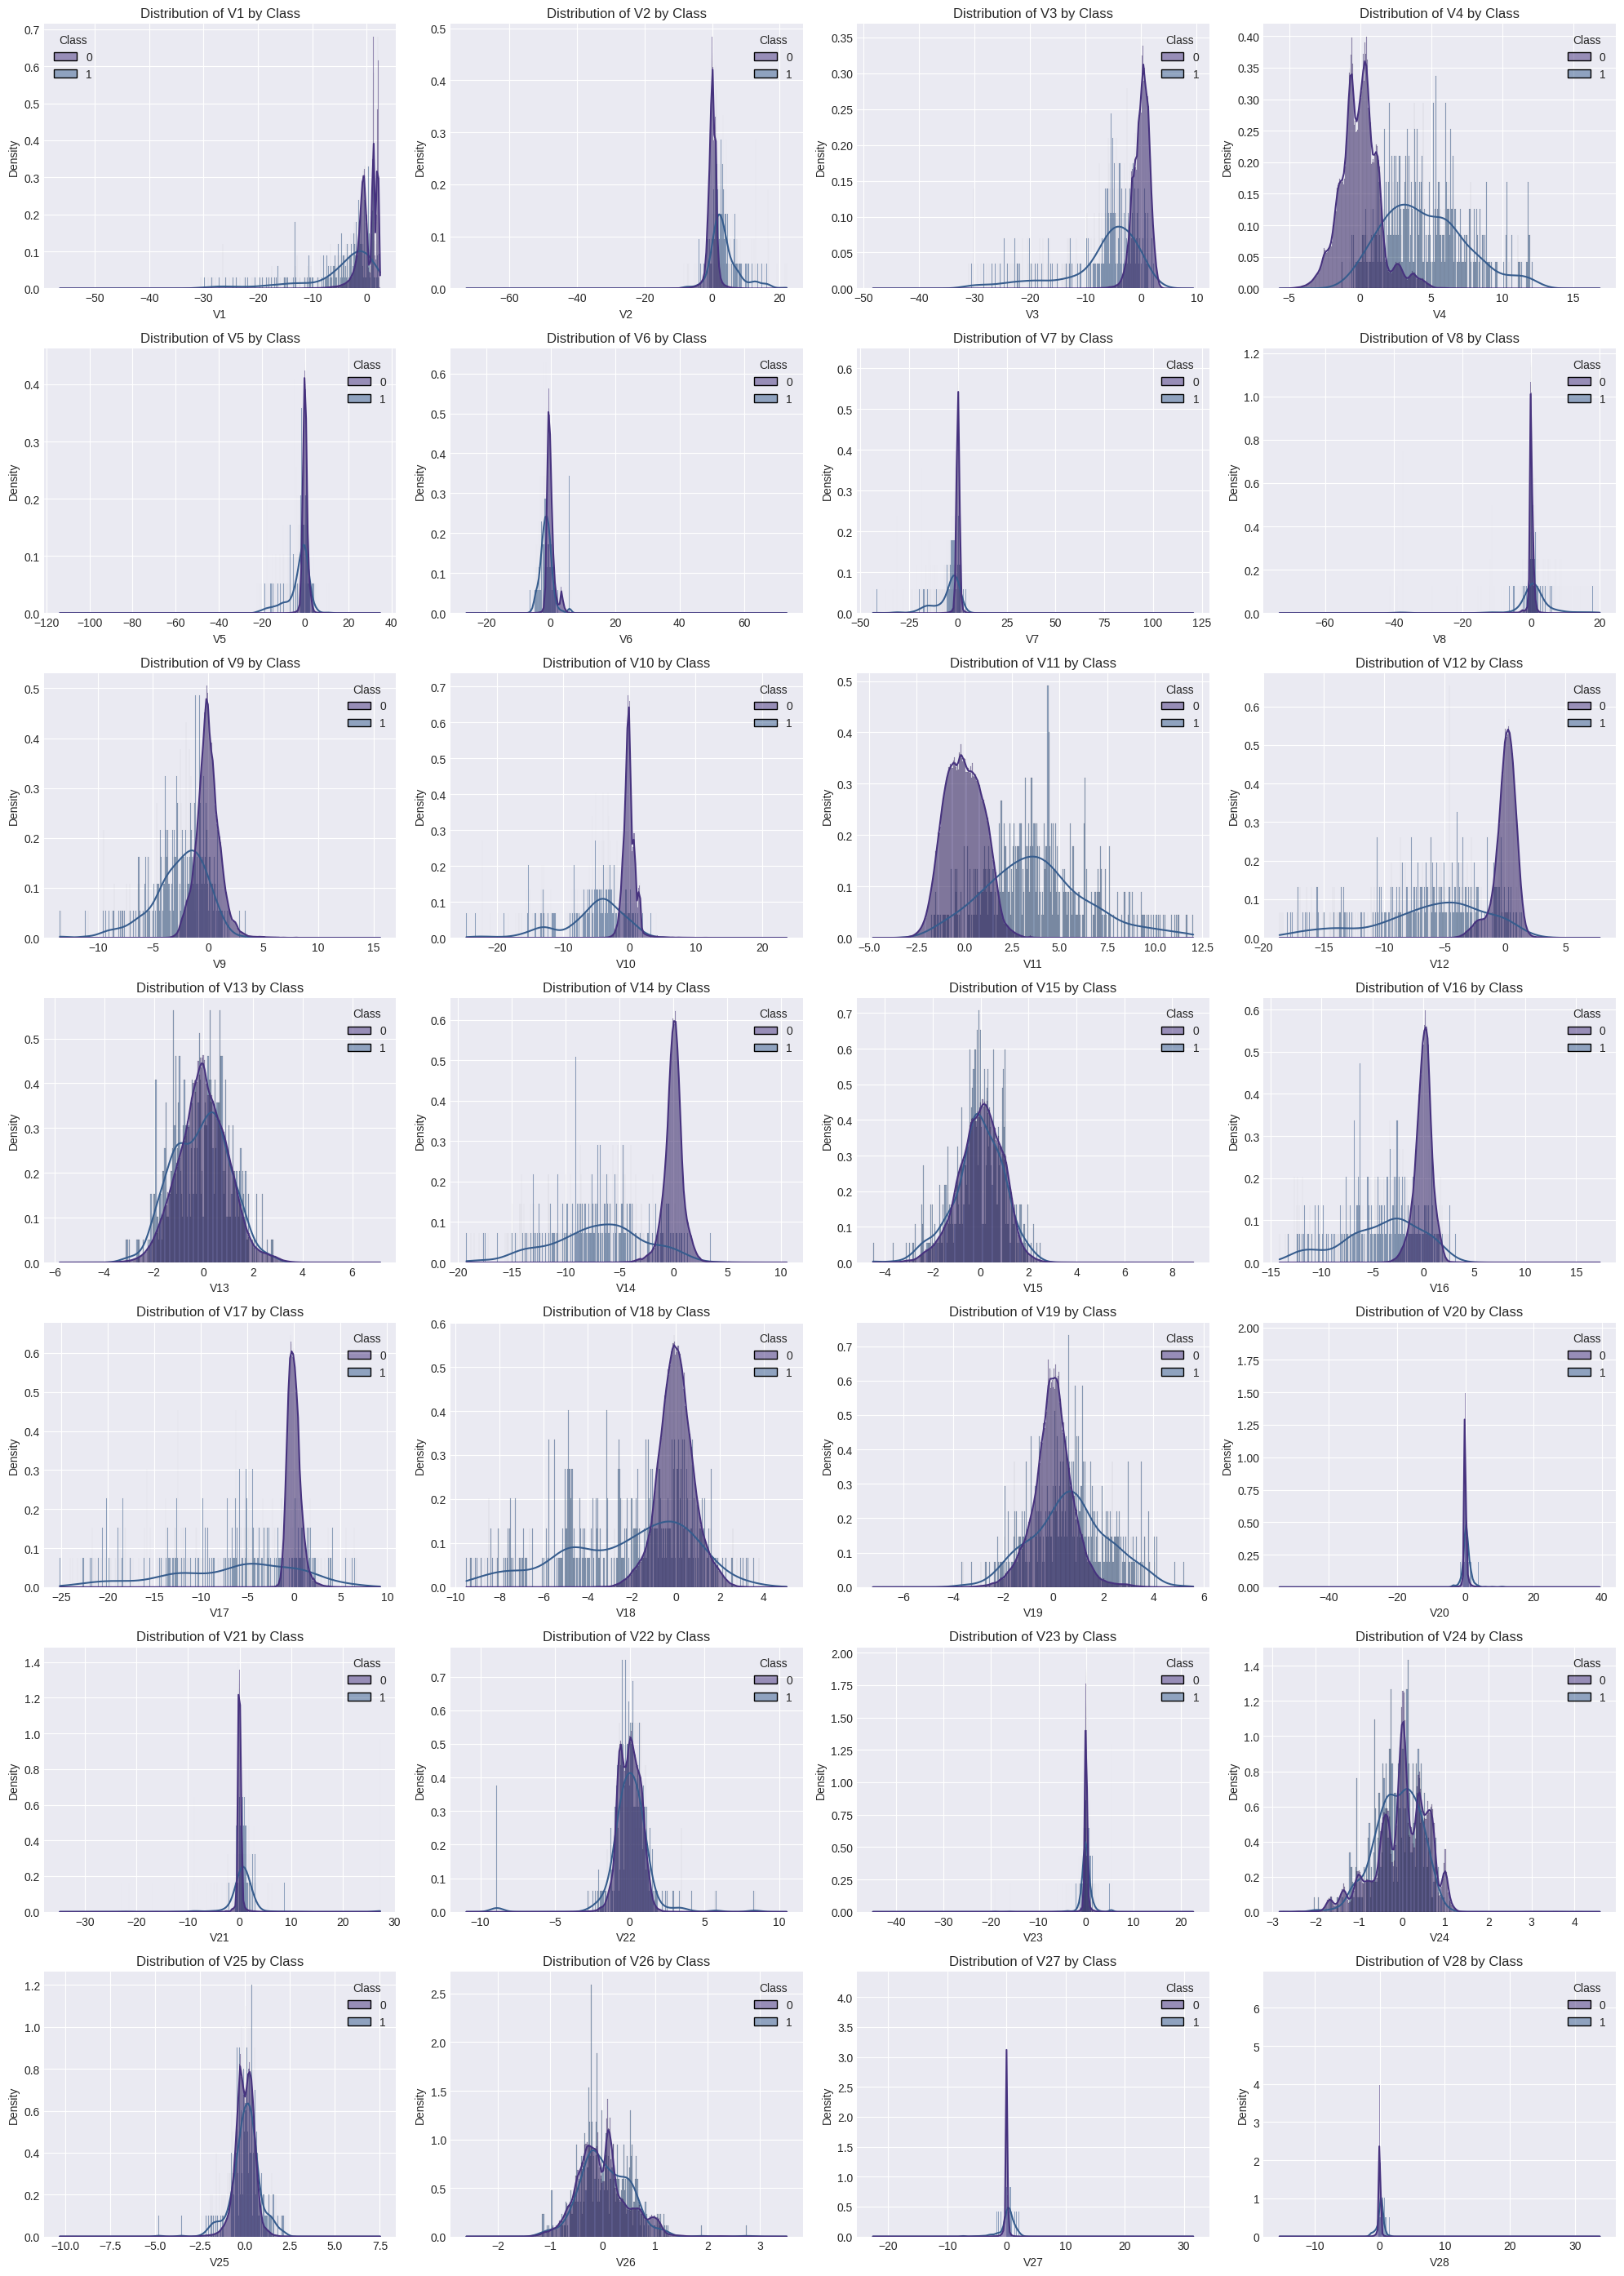

In [3]:
# List of all V-features (V1 to V28)
all_v_features = [f'V{i}' for i in range(1, 29)]

n_features = len(all_v_features) 
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols # Calculate rows needed

plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figsize

for i, feature in enumerate(all_v_features): # or iterate through features_to_explore
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=df, x=feature, hue='Class', kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
from scipy import stats

# Separate data for fraudulent and non-fraudulent transactions
fraud_df = df[df['Class'] == 1]
non_fraud_df = df[df['Class'] == 0]

features_to_test = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)] # Add V-features
alpha = 0.05 # Significance level

results = []

for feature in features_to_test:
    feature_fraud_data = fraud_df[feature].dropna()
    feature_non_fraud_data = non_fraud_df[feature].dropna()

    t_stat, p_value_ttest = stats.ttest_ind(feature_fraud_data,
                                            feature_non_fraud_data,
                                            equal_var=False) 

    # --- Mann-Whitney U Test ---
    try:
        u_stat, p_value_mannwhitneyu = stats.mannwhitneyu(feature_fraud_data,
                                                      feature_non_fraud_data,
                                                      alternative='two-sided') 
    except ValueError as e: # Can occur if one sample is too small or all values are identical
        u_stat, p_value_mannwhitneyu = None, None
        print(f"Mann-Whitney U test failed for {feature}: {e}")


    # --- Kolmogorov-Smirnov Two-Sample Test ---
    ks_stat, p_value_ks = stats.ks_2samp(feature_fraud_data,
                                         feature_non_fraud_data)

    results.append({
        'feature': feature,
        't_statistic': t_stat,
        'p_value_ttest': p_value_ttest,
        'u_statistic': u_stat,
        'p_value_mannwhitneyu': p_value_mannwhitneyu,
        'ks_statistic': ks_stat,
        'p_value_ks': p_value_ks
    })

results_df = pd.DataFrame(results)
print(results_df)


print("\nFeatures with significantly different means (T-test, alpha=0.05):")
print(results_df[results_df['p_value_ttest'] < alpha]['feature'].tolist())

print("\nFeatures with significantly different distributions (Mann-Whitney U, alpha=0.05):")
print(results_df[results_df['p_value_mannwhitneyu'] < alpha]['feature'].tolist())

print("\nFeatures with significantly different distributions (KS-test, alpha=0.05):")
print(results_df[results_df['p_value_ks'] < alpha]['feature'].tolist())

   feature  t_statistic  p_value_ttest  u_statistic  p_value_mannwhitneyu  \
0     Time    -6.528562   1.654564e-10   58572378.0          4.386159e-10   
1   Amount     2.928790   3.560519e-03   61833399.0          8.578472e-06   
2       V1   -15.629065   5.491643e-45   28689110.0         1.740785e-113   
3       V2    18.761177   1.288580e-59  119593684.0         1.650438e-163   
4       V3   -21.976004   4.786081e-75   12299525.0         1.211048e-219   
5       V4    35.116449  4.587317e-136  131246382.0         3.625904e-248   
6       V5   -13.032119   1.497028e-33   40626254.0          3.053712e-58   
7       V6   -16.706743   5.880378e-50   32591968.0          2.231002e-93   
8       V7   -17.168755   4.292231e-52   22967158.0         1.464234e-146   
9       V8     1.865139   6.275812e-02   92020960.0          8.509891e-34   
10      V9   -22.928481   1.193505e-79   21809136.0         8.943723e-154   
11     V10   -25.755260   3.382884e-93   12021914.0         9.611131e-222   

In [6]:
features_to_analyze = ['Amount'] + [f'V{i}' for i in range(1, 29)]
class_column = 'Class'

# Prepare lists to store results
results_list = []

for feature in features_to_analyze:
    # Group by class for the current feature
    grouped_feature = df.groupby(class_column)[feature]

    try:
        skew_values = grouped_feature.agg(pd.Series.skew)
        kurt_values = grouped_feature.agg(pd.Series.kurt) 

        results_list.append({
            'Feature': feature,
            'Skew_Class0': skew_values.get(0, None),
            'Skew_Class1': skew_values.get(1, None),
            'Kurt_Class0': kurt_values.get(0, None),
            'Kurt_Class1': kurt_values.get(1, None)
        })
    except Exception as e:
        print(f"Could not process feature {feature}: {e}")


# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

print("--- Skewness and Kurtosis (Excess) by Class ---")
print(results_df)

--- Skewness and Kurtosis (Excess) by Class ---
   Feature  Skew_Class0  Skew_Class1  Kurt_Class0  Kurt_Class1
0   Amount    17.003147     3.754477   846.736996    17.745687
1       V1    -3.130188    -1.797617    31.065568     2.879609
2       V2    -4.887166     1.226561    98.406211     2.597563
3       V3    -1.453676    -1.514985    14.545345     1.781004
4       V4     0.581137     0.496746     2.095716    -0.197493
5       V5    -2.213903    -1.361139   217.852170     1.728831
6       V6     1.842604     0.867734    42.987534     2.876068
7       V7     4.747800    -1.827599   452.920870     4.245361
8       V8    -8.395492    -2.830022   209.772662    16.764743
9       V9     0.665635    -0.975075     3.196847     1.494887
10     V10     2.422278    -1.152719    21.961970     1.450166
11     V11     0.145537     0.499090     0.035641     0.207397
12     V12    -1.256301    -0.666830     5.300894    -0.196194
13     V13     0.065582    -0.025996     0.196578    -0.434002
14     

In [2]:
# Seconds in a day
seconds_in_day = 24 * 60 * 60

# Calculate 'Hour of Day'
# This gives the second within a 24-hour cycle
df['Time_Sec_of_Day'] = df['Time'] % seconds_in_day
# Convert seconds within the day to hour
df['Time_Hour_of_Day'] = df['Time_Sec_of_Day'] // 3600 # (3600 seconds in an hour)

print("First 5 rows with new time features:")
print(df[['Time', 'Time_Sec_of_Day', 'Time_Hour_of_Day']].head())

First 5 rows with new time features:
   Time  Time_Sec_of_Day  Time_Hour_of_Day
0   0.0              0.0               0.0
1   0.0              0.0               0.0
2   1.0              1.0               0.0
3   1.0              1.0               0.0
4   2.0              2.0               0.0


/tmp/ipykernel_4423/4001833104.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Time_Hour_of_Day', data=df[df['Class'] == 1], palette='viridis')


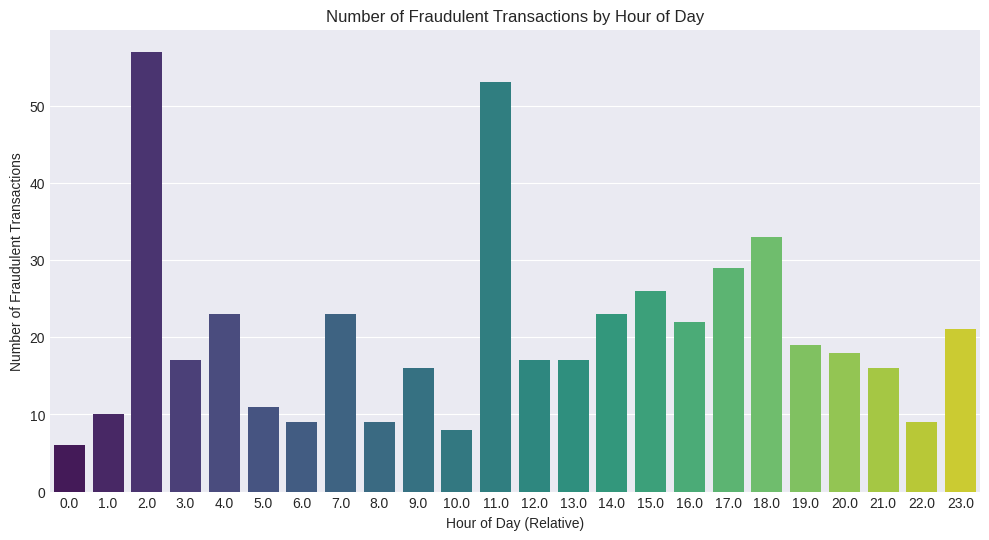

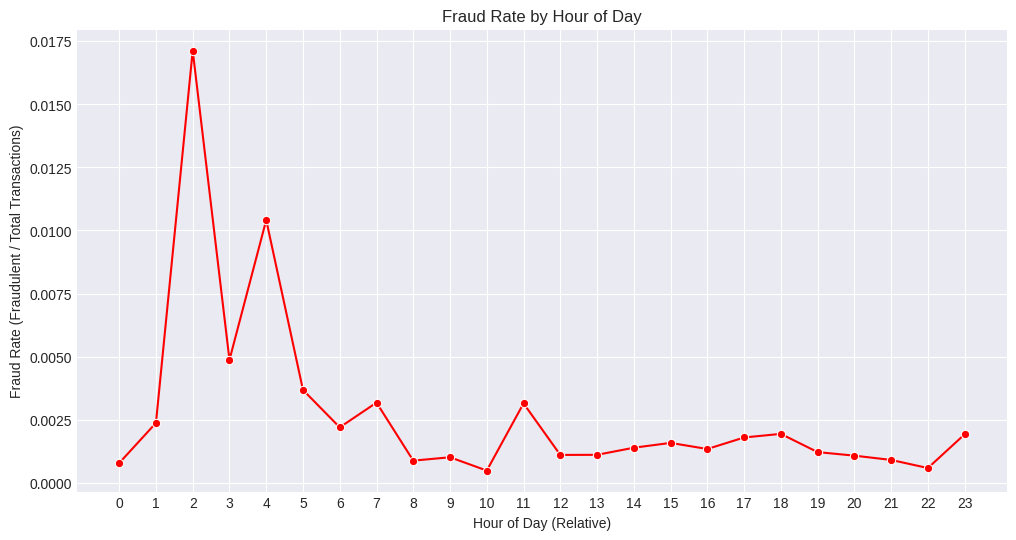


Hourly fraud summary:
                  Total_Transactions  Fraud_Transactions  Fraud_Rate
Time_Hour_of_Day                                                    
0.0                             7695                   6    0.000780
1.0                             4220                  10    0.002370
2.0                             3328                  57    0.017127
3.0                             3492                  17    0.004868
4.0                             2209                  23    0.010412
5.0                             2990                  11    0.003679
6.0                             4101                   9    0.002195
7.0                             7243                  23    0.003175
8.0                            10276                   9    0.000876
9.0                            15838                  16    0.001010
10.0                           16598                   8    0.000482
11.0                           16856                  53    0.003144
12.0       

In [3]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Time_Hour_of_Day', data=df[df['Class'] == 1], palette='viridis')
plt.title('Number of Fraudulent Transactions by Hour of Day')
plt.xlabel('Hour of Day (Relative)')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

# To visualize fraud rate by hour:
hourly_summary = df.groupby('Time_Hour_of_Day')['Class'].agg(['count', 'sum'])
hourly_summary.rename(columns={'count': 'Total_Transactions', 'sum': 'Fraud_Transactions'}, inplace=True)
hourly_summary['Fraud_Rate'] = hourly_summary['Fraud_Transactions'] / hourly_summary['Total_Transactions']

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_summary.index, y='Fraud_Rate', data=hourly_summary, marker='o', color='red')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day (Relative)')
plt.ylabel('Fraud Rate (Fraudulent / Total Transactions)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

print("\nHourly fraud summary:")
print(hourly_summary)

In [8]:
v_features = [f'V{i}' for i in range(1, 29)]

# Separate data by class
df_non_fraud = df[df['Class'] == 0][v_features]
df_fraud = df[df['Class'] == 1][v_features]

corr_non_fraud = df_non_fraud.corr()

corr_fraud = df_fraud.corr()

print("--- Correlation Matrix for Non-Fraudulent Transactions (First 5x5) ---")
print(corr_non_fraud.iloc[:5, :5])
print("\n--- Correlation Matrix for Fraudulent Transactions (First 5x5) ---")
print(corr_fraud.iloc[:5, :5])

--- Correlation Matrix for Non-Fraudulent Transactions (First 5x5) ---
          V1        V2        V3        V4        V5
V1  1.000000  0.022537 -0.047511  0.020927 -0.031465
V2  0.022537  1.000000  0.037855 -0.018318  0.023772
V3 -0.047511  0.037855  1.000000  0.039621 -0.048840
V4  0.020927 -0.018318  0.039621  1.000000  0.020792
V5 -0.031465  0.023772 -0.048840  0.020792  1.000000

--- Correlation Matrix for Fraudulent Transactions (First 5x5) ---
          V1        V2        V3        V4        V5
V1  1.000000 -0.819226  0.907875 -0.562688  0.894968
V2 -0.819226  1.000000 -0.876904  0.629688 -0.828391
V3  0.907875 -0.876904  1.000000 -0.723766  0.883689
V4 -0.562688  0.629688 -0.723766  1.000000 -0.550242
V5  0.894968 -0.828391  0.883689 -0.550242  1.000000


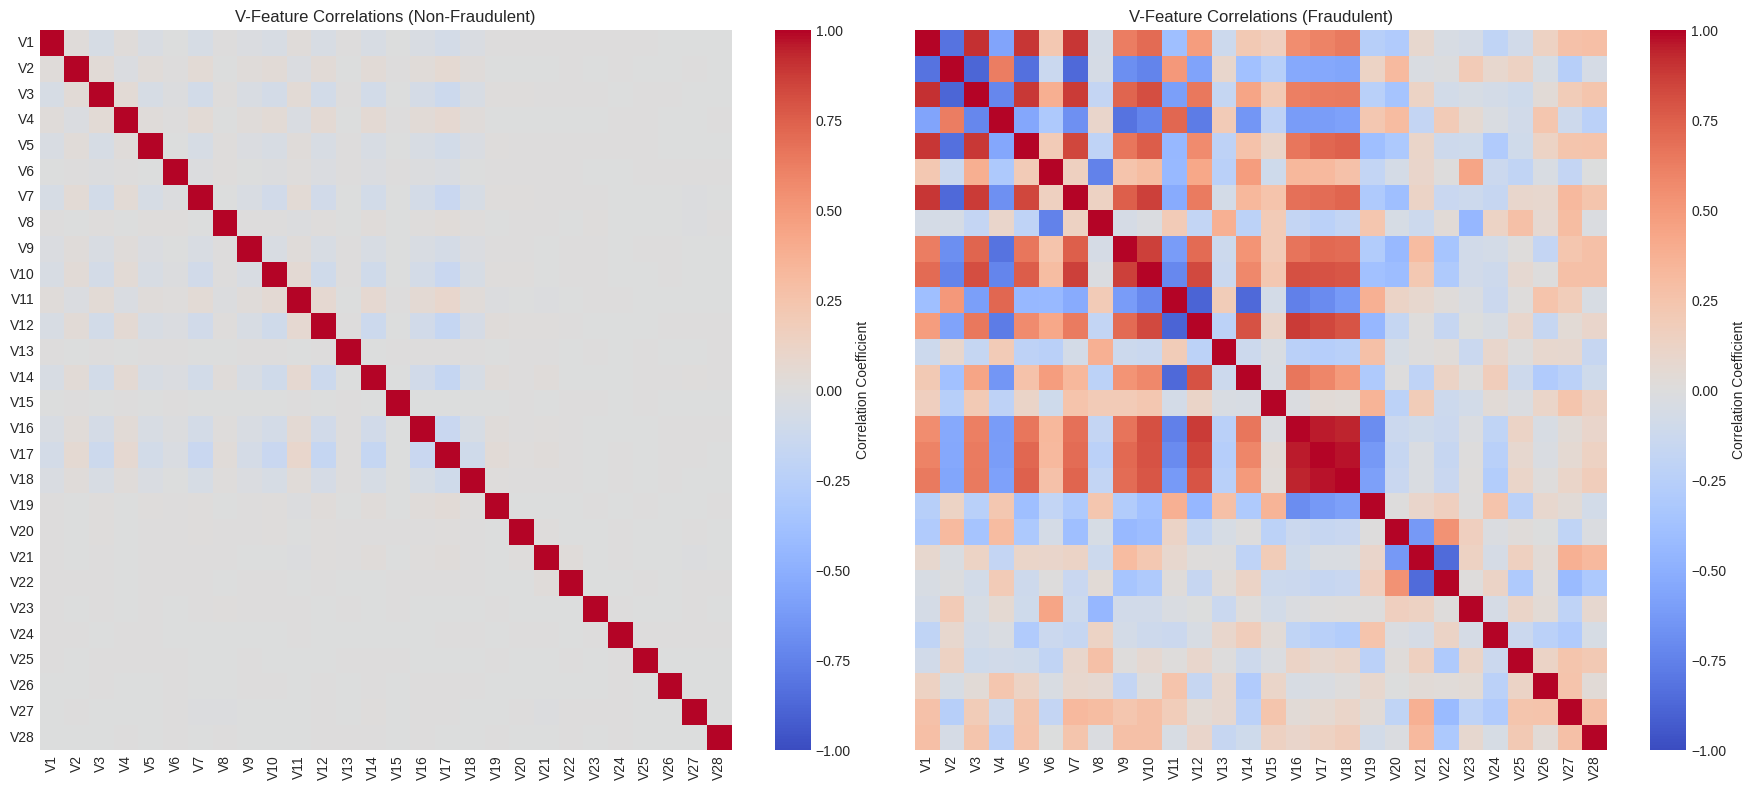

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True) # sharey can be useful

sns.heatmap(corr_non_fraud, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
axes[0].set_title('V-Feature Correlations (Non-Fraudulent)')

sns.heatmap(corr_fraud, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
axes[1].set_title('V-Feature Correlations (Fraudulent)')

plt.tight_layout()
plt.show()

## Preprocessing and Data Splitting


In [17]:
print("\nSeparate Features (X) and Target (y)")

# Features (X) are all columns except 'Class'
X = df.drop('Class', axis=1)

# Target (y) is the 'Class' column
y = df['Class']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFirst 5 rows of X:")
print(X.head())
print("\nFirst 5 values of y:")
print(y.head())


Separate Features (X) and Target (y)
Features (X) shape: (284807, 32)
Target (y) shape: (284807,)

First 5 rows of X:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V22       V23       V24       V25       V26  \
0  0.098698  0.363787  ...  0.277838 -0.110474  0.066928  0.128539 -0.189115   
1  0.085102 -0.255425  ... -0.638672  0.101288 -0.339846  0.167170  0.125895   
2  0.247676 -1.514654  ...  0.771679  0.909412 -0.689281 -0.327642 -0.139097   
3  0.377436 -1.387024  ...  0.005274 -0.190321 -1.175575  0.647376 -0.2219

X = df.drop('Class', axis=1): Creates a new DataFrame X by dropping the 'Class' column from the original DataFrame df. axis=1 specifies that we are dropping a column.
y = df['Class']: Creates a Series y containing only the 'Class' column, which is our target variable (0 for non-fraud, 1 for fraud).
The print statements confirm the shapes of the new X and y objects, and display their first few entries for verification.

## Define Features for Scaling

In [18]:
print("\nDefine Features for Scaling ")

numerical_features_to_scale = ['Time', 'Amount']

features_not_to_scale = [col for col in X.columns if col.startswith('V')]

print(f"Features to scale: {numerical_features_to_scale}")
print(f"Features not to scale (PCA-transformed): {features_not_to_scale[:5]} ... {features_not_to_scale[-5:]}")


Define Features for Scaling 
Features to scale: ['Time', 'Amount']
Features not to scale (PCA-transformed): ['V1', 'V2', 'V3', 'V4', 'V5'] ... ['V24', 'V25', 'V26', 'V27', 'V28']


numerical_features_to_scale: A list explicitly stating the columns ('Time', 'Amount') that will undergo StandardScaler transformation.
features_not_to_scale: A list comprehension identifies all columns starting with 'V' (e.g., 'V1', 'V2', ..., 'V28'). These will be included in the dataset but will bypass the scaler.

## Create Preprocessing Pipeline using ColumnTransformer

In [19]:
print("\nCreate Preprocessing Pipeline using ColumnTransformer")

# Create a ColumnTransformer to apply StandardScaler only to specified numerical features.

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_features_to_scale)
    ],
    remainder='passthrough'
)

print("\nColumnTransformer created. It will apply StandardScaler to 'Time' and 'Amount' and pass through other features.")


Create Preprocessing Pipeline using ColumnTransformer

ColumnTransformer created. It will apply StandardScaler to 'Time' and 'Amount' and pass through other features.


## Train-Test Split with Stratification


In [21]:
print("\nTrain-Test Split with Stratification")

# Initialize StratifiedKFold for cross-validation during GridSearchCV.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("StratifiedKFold (5-fold) initialized for robust cross-validation.")

# Perform the train-test split for final model evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set features (X_train) shape: {X_train.shape}")
print(f"Training set target (y_train) shape: {y_train.shape}")
print(f"Test set features (X_test) shape: {X_test.shape}")
print(f"Test set target (y_test) shape: {y_test.shape}")

# Verify the class distribution in the splits
print("\nClass distribution in Training set:")
print(y_train.value_counts(normalize=True))
print("Class distribution in Test set:")
print(y_test.value_counts(normalize=True))

# Confirm that the number of fraudulent cases is consistent
print(f"\nFraudulent cases in Training set: {y_train.sum()}")
print(f"Fraudulent cases in Test set: {y_test.sum()}")


Train-Test Split with Stratification
StratifiedKFold (5-fold) initialized for robust cross-validation.

Training set features (X_train) shape: (227845, 32)
Training set target (y_train) shape: (227845,)
Test set features (X_test) shape: (56962, 32)
Test set target (y_test) shape: (56962,)

Class distribution in Training set:
0    0.998271
1    0.001729
Name: Class, dtype: float64
Class distribution in Test set:
0    0.99828
1    0.00172
Name: Class, dtype: float64

Fraudulent cases in Training set: 394
Fraudulent cases in Test set: 98


# Model Building and Evaluation

In [28]:
print("\nDefine Models and Hyperparameter Grids")

# Define Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',
                                 scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))
}

# Define Hyperparameter Grids for GridSearchCV

param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10] # smaller C means stronger regularization
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 7, None], # Max depth of the tree
        'classifier__min_samples_leaf': [1, 5, 10] # Minimum number of samples required to be at a leaf node
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200], # Number of trees in the forest
        'classifier__max_depth': [5, 10], # Max depth for each tree
        'classifier__min_samples_leaf': [5, 10] # Min samples per leaf for each tree
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200], # Number of boosting rounds (trees)
        'classifier__max_depth': [3, 5], # Max depth of a tree
        'classifier__learning_rate': [0.01, 0.1] # Step size shrinkage to prevent overfitting
    }
}
print("Hyperparameter grids defined for each model.")

results = {}


Define Models and Hyperparameter Grids
Hyperparameter grids defined for each model.


## Train, Tune, and Evaluate Each Model



--- 4.2 Training, Tuning, and Evaluating Each Model ---

===== Training and Tuning: Logistic Regression =====
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Logistic Regression: {'classifier__C': 0.01}

Performance for Logistic Regression on Test Set:
  Accuracy (misleading for imbalance): 0.9758
  Precision (Fraud Class): 0.0616
  Recall (Fraud Class): 0.9184
  F1-Score (Fraud Class): 0.1155
  ROC AUC Score: 0.9725
  Confusion Matrix:


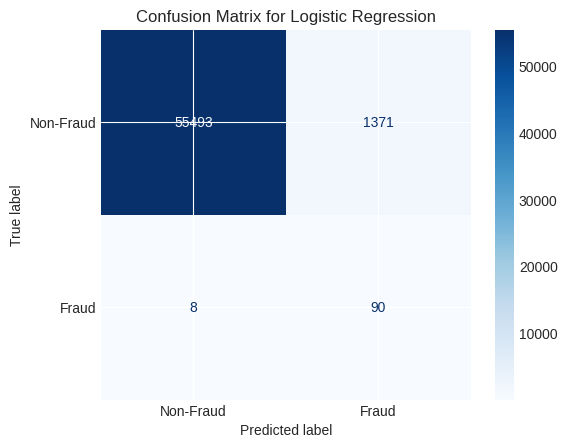


--- Coefficients for Logistic Regression (Logistic Regression) ---
               Feature  Coefficient
5        remainder__V4     0.921443
1   num_scaler__Amount     0.825811
23      remainder__V22     0.602663
29      remainder__V28     0.445728
6        remainder__V5     0.405913
2        remainder__V1     0.402664
12      remainder__V11     0.317884
22      remainder__V21     0.186667
3        remainder__V2     0.063334
20      remainder__V19     0.038436

Features with most negative coefficients:
             Feature  Coefficient
27    remainder__V26    -0.337347
0   num_scaler__Time    -0.365706
14    remainder__V13    -0.410455
9      remainder__V8    -0.471115
21    remainder__V20    -0.559016
18    remainder__V17    -0.605658
17    remainder__V16    -0.760113
13    remainder__V12    -0.767678
11    remainder__V10    -0.894750
15    remainder__V14    -1.132370

===== Training and Tuning: Decision Tree =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best param

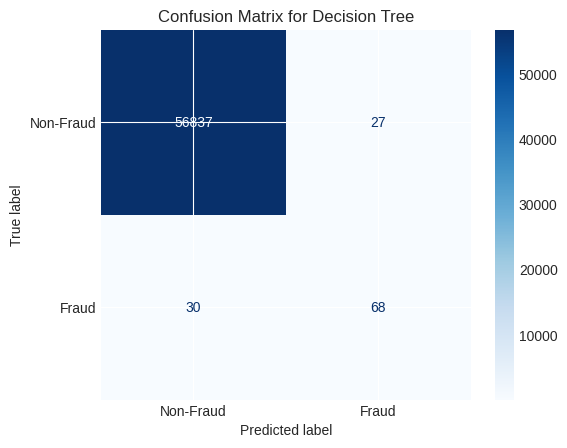


--- Feature Importance for Decision Tree ---
           Feature  Importance
15  remainder__V14    0.732875
5    remainder__V4    0.067405
13  remainder__V12    0.025502
14  remainder__V13    0.021932
9    remainder__V8    0.016462
19  remainder__V18    0.015162
21  remainder__V20    0.014462
16  remainder__V15    0.012230
11  remainder__V10    0.011879
8    remainder__V7    0.010971


<ipython-input-13-befa99399a8e>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


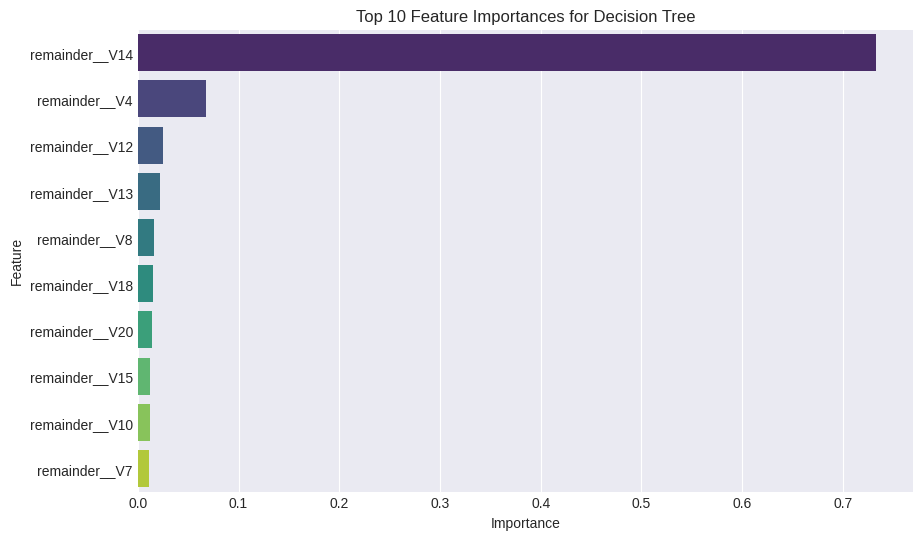


===== Training and Tuning: Random Forest =====
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 100}

Performance for Random Forest on Test Set:
  Accuracy (misleading for imbalance): 0.9993
  Precision (Fraud Class): 0.7593
  Recall (Fraud Class): 0.8367
  F1-Score (Fraud Class): 0.7961
  ROC AUC Score: 0.9746
  Confusion Matrix:


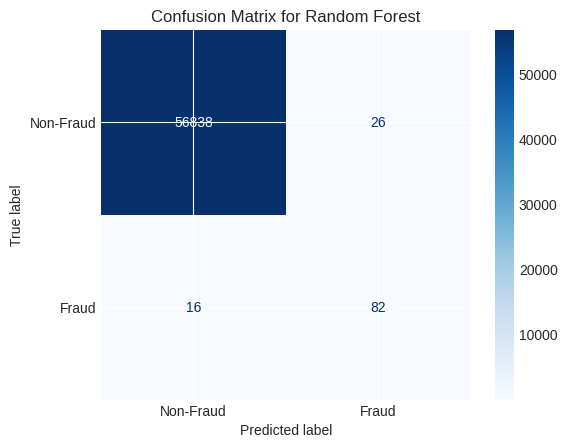


--- Feature Importance for Random Forest ---
           Feature  Importance
15  remainder__V14    0.226665
13  remainder__V12    0.138188
5    remainder__V4    0.112119
11  remainder__V10    0.080153
12  remainder__V11    0.075918
18  remainder__V17    0.063503
4    remainder__V3    0.048615
8    remainder__V7    0.034995
3    remainder__V2    0.024029
17  remainder__V16    0.020179


<ipython-input-13-befa99399a8e>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


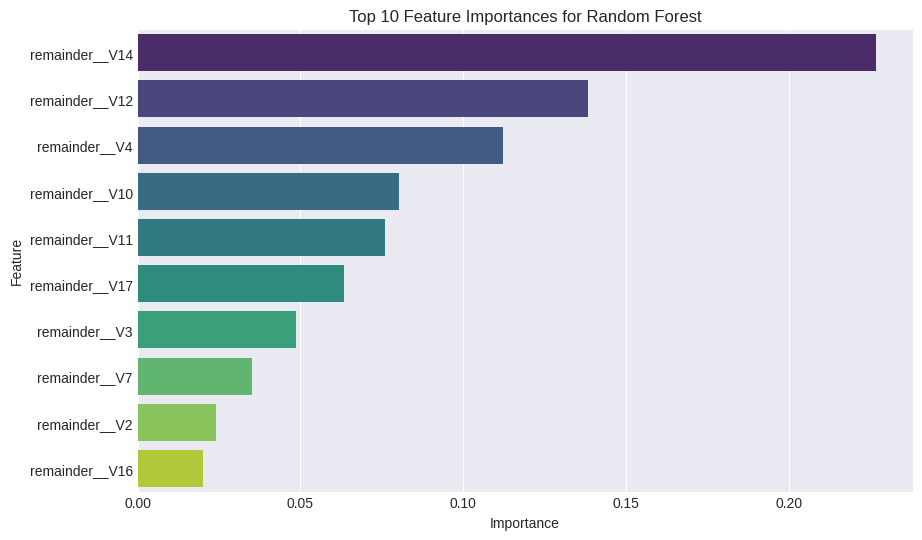


===== Training and Tuning: XGBoost =====
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:43:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

Performance for XGBoost on Test Set:
  Accuracy (misleading for imbalance): 0.9994
  Precision (Fraud Class): 0.8367
  Recall (Fraud Class): 0.8367
  F1-Score (Fraud Class): 0.8367
  ROC AUC Score: 0.9778
  Confusion Matrix:


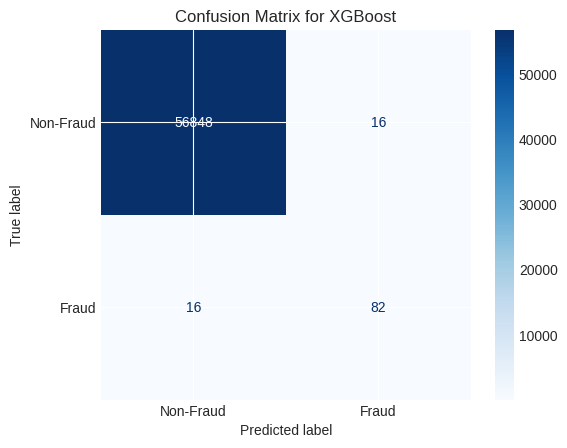


--- Feature Importance for XGBoost ---
               Feature  Importance
15      remainder__V14    0.514525
5        remainder__V4    0.067818
13      remainder__V12    0.042477
9        remainder__V8    0.028996
1   num_scaler__Amount    0.021902
8        remainder__V7    0.020270
21      remainder__V20    0.019243
11      remainder__V10    0.019143
14      remainder__V13    0.018105
29      remainder__V28    0.017853


<ipython-input-13-befa99399a8e>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


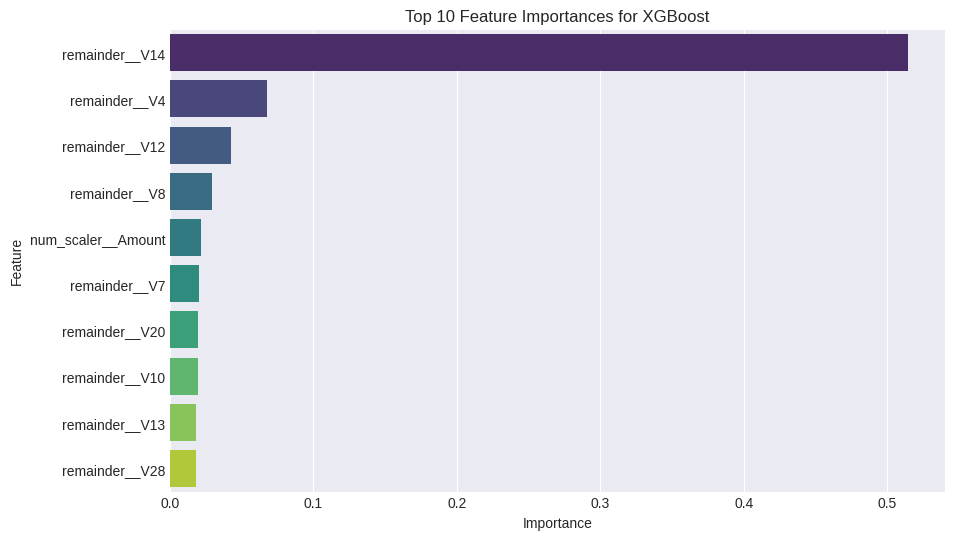

In [13]:
print("\n--- 4.2 Training, Tuning, and Evaluating Each Model ---")

for model_name, model in models.items():
    print(f"\n===== Training and Tuning: {model_name} =====")

    # Create a full pipeline: preprocessing -> classifier
    # This ensures consistent scaling is applied within each GridSearchCV iteration.
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', model)])

    # Perform GridSearchCV for hyperparameter tuning.
    # estimator: The pipeline to tune.
    # param_grid: The specific hyperparameter grid for the current model.
    # cv=skf: Use StratifiedKFold for cross-validation to maintain class balance in each fold.
    # scoring='f1': Optimize GridSearchCV based on the F1-score of the minority class, which is suitable for imbalance.
    # n_jobs=-1: Use all available CPU cores for faster computation.
    # verbose=1: Print progress messages.
    grid_search = GridSearchCV(full_pipeline, param_grids[model_name], cv=skf, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train) # Fit GridSearchCV on the training data

    # Store the best model and its parameters
    best_model = grid_search.best_estimator_
    results[model_name] = {'best_model': best_model, 'best_params': grid_search.best_params_}

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # --- Evaluate the best model on the test set ---
    # Make predictions on the held-out test set
    y_pred = best_model.predict(X_test)
    # Get probability scores for the positive class (fraud) for ROC AUC calculation
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate and store performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[model_name].update({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': conf_matrix
    })

    print(f"\nPerformance for {model_name} on Test Set:")
    print(f"  Accuracy (misleading for imbalance): {accuracy:.4f}")
    print(f"  Precision (Fraud Class): {precision:.4f}")
    print(f"  Recall (Fraud Class): {recall:.4f}")
    print(f"  F1-Score (Fraud Class): {f1:.4f}")
    print(f"  ROC AUC Score: {roc_auc:.4f}")
    print("  Confusion Matrix:")
    # Visualize the confusion matrix
    cmd_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Fraud', 'Fraud'])
    cmd_display.plot(cmap='Blues', values_format='d') # 'd' for integer format
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # --- 4.3 Feature Importance (for tree-based models) or Coefficients (for linear models) ---
    # Extract feature importances for tree-based models
    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        print(f"\n--- Feature Importance for {model_name} ---")
        feature_importances = best_model.named_steps['classifier'].feature_importances_

        # Get feature names from the preprocessor's output to correctly map importances
        # This handles the scaled 'Time', 'Amount' and the 'passthrough' V-features
        preprocessed_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

        # Create a DataFrame for better visualization and sorting
        importance_df = pd.DataFrame({
            'Feature': preprocessed_feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

        print(importance_df.head(10)) # Display top 10 most important features

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
        plt.title(f'Top 10 Feature Importances for {model_name}')
        plt.show()

    # Extract coefficients for linear models (like Logistic Regression)
    elif hasattr(best_model.named_steps['classifier'], 'coef_'):
        print(f"\n--- Coefficients for {model_name} (Logistic Regression) ---")
        coefficients = best_model.named_steps['classifier'].coef_[0] # For binary classification, coef_ is 2D
        preprocessed_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

        coef_df = pd.DataFrame({
            'Feature': preprocessed_feature_names,
            'Coefficient': coefficients
        }).sort_values(by='Coefficient', ascending=False)
        print(coef_df.head(10)) # Display features with largest positive coefficients
        print("\nFeatures with most negative coefficients:")
        print(coef_df.tail(10)) # Display features with largest negative coefficients